In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
import pytorch_lightning as pl
import torch.nn as nn
import torch.nn.functional as F
from torchmetrics.classification import Accuracy
import torch.optim as optim
from pytorch_lightning.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Disclaimer
This cheatsheet is for people who already have some ML/DL experience as it does not explain the concepts in detail. It is meant to be a quick reference guide for the most common operations in PyTorch. Code that are self-descriptive will not be elaborated on.

> Idhibhat Pankam 6532203021

In [ ]:
# check device if gpu (cuda) is available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## Pytorch classes

### Dataset

In [ ]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self):
        super().__init__()
        # do anything to load your data here, e.g. download, read from disk, etc.
        # e.g. out into self.data

    def __getitem__(self, idx):
        # get the idx-th item of your data
        x, y = self.data[idx]
        return x,y

### Model

In [ ]:
class Model(pl.LightningModule):
    def __init__(self):
        super(Model, self).__init__()
        # declare the layers/activation fn/loss fn for your neural network
    
    def forward(self, x):
        # forward pass
        # do a non-linearity after CNN before pooling
        return x

    def training_step(self, batch, batch_idx):
        # get x, y from batch (depends on how you created the batch in dataloader)
        logits = self(x) # self(x) is same as self.forward(x)
        loss = self.criterion(logits, y)
        return loss

    def validation_step(self, batch, batch_idx):
        # practically same as training_step, but pytorch automatically does torch.no_grad() for you
        pass

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=1e-3)

# Image classification: CNN 

#### Model
- 2 CNNs with max poolings -> 3 fully connected layers -> softmax
- Adam optimizer, lr=1e-3

### Dataset
- 60k images of 10 classes ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
- 40k training, 10k validation, 10k test

#### Input
a batch (size 32) of 3-channel images of size 32x32

#### Output
a batch (size 32) of class scores (10 classes) for each image

#### Metrics
- accuracy
- loss: cross-entropy loss

## Results
after 1 epoch:
- train loss: 2.2, acc: 0.242
- val loss: 2.16, acc: 0.286
- test loss: 2.158, acc: 0.288
### macro avg
- precision: 0.2577
- recall: 0.2884
- f1: 0.2508

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(), # image to tensor --> divide by 255
     transforms.Resize((32, 32))])

batch_size = 32
trainvalset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainset, valset = torch.utils.data.random_split(trainvalset, [40000, 10000])

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

In [ ]:
class CNN(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5) # 3 input channels, 6 output channels, 5*5 kernel size
        self.pool = nn.MaxPool2d(2, 2) # 2*2 kernel size, 2 strides
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(400, 120) # dense input 400 (16*5), output 120

        self.fc2 = nn.Linear(120, 84) # dense input 120, output 84
        self.fc3 = nn.Linear(84, 10) # dense input 84, output 10
        self.softmax = torch.nn.Softmax(dim=1) # perform softmax at dim[1] (batch,class)

        self.criterion = nn.CrossEntropyLoss()
        self.accuracy = Accuracy(task="multiclass", num_classes=10)
        self.train_loss = []
        self.train_acc = []
        self.val_loss = []
        self.val_acc = []
        self.train_metrics_epoch = []
        self.val_metrics_epoch = []
        self.n_ = 0

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x,start_dim=1) # flatten all dimensions (dim[1]) except batch (dim[0])
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = self.softmax(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        acc = self.accuracy(logits.softmax(dim=-1), y)
        self.train_loss.append(loss)
        self.train_acc.append(acc)

        # Log metrics
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log("train_acc", acc, on_step=True, on_epoch=True, prog_bar=True)
        return loss

    def on_train_epoch_end(self):
        # Collect epoch metrics
        self.train_metrics_epoch.append({"train_loss": sum(self.train_loss)/len(self.train_loss), "train_acc": sum(self.train_acc)/len(self.train_acc)})
        self.train_loss = []
        self.train_acc = []

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        acc = self.accuracy(logits.softmax(dim=-1), y)
        self.val_loss.append(loss)
        self.val_acc.append(acc)

        # Log metrics
        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log("val_acc", acc, on_step=False, on_epoch=True, prog_bar=True)

    def on_validation_epoch_end(self):
        # Update validation metrics
        self.val_metrics_epoch.append({"val_loss": sum(self.val_loss)/len(self.val_loss), "val_acc": sum(self.val_acc)/len(self.val_acc)})
        self.val_loss = []
        self.val_acc = []

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=1e-3)

net = CNN().to(device)

In [ ]:
from torchinfo import summary as summary_info
# summarizes model architecture
print(summary_info(net, input_size = (32, 3, 32, 32)))

In [ ]:
checkpoint_callback = ModelCheckpoint(
    monitor="val_acc",       # Monitor validation accuracy
    mode="max",              # Save the model with the highest accuracy
    save_top_k=1,            # Save only the best model
    filename="best-acc-{epoch:02d}-{val_acc:.4f}",  # File name format
    verbose=True             # Print messages when saving
)

trainer = pl.Trainer(max_epochs=1, callbacks=[checkpoint_callback])
trainer.fit(net, trainloader, valloader)

In [ ]:
fig, axs = plt.subplots(2, figsize= (6,10))
# loss
axs[0].plot([round(float(entry['train_loss']), 2) for entry in net.train_metrics_epoch], label = 'training')
axs[0].plot([round(float(entry['val_loss']), 2) for entry in net.val_metrics_epoch], label = 'validation')
axs[0].set_title("loss")
axs[0].legend()
# acc
axs[1].plot([round(float(entry['train_acc']), 2) for entry in net.train_metrics_epoch], label = 'training')
axs[1].plot([round(float(entry['val_acc']), 2) for entry in net.val_metrics_epoch], label = 'validation')
axs[1].set_title("acc")
axs[1].legend()

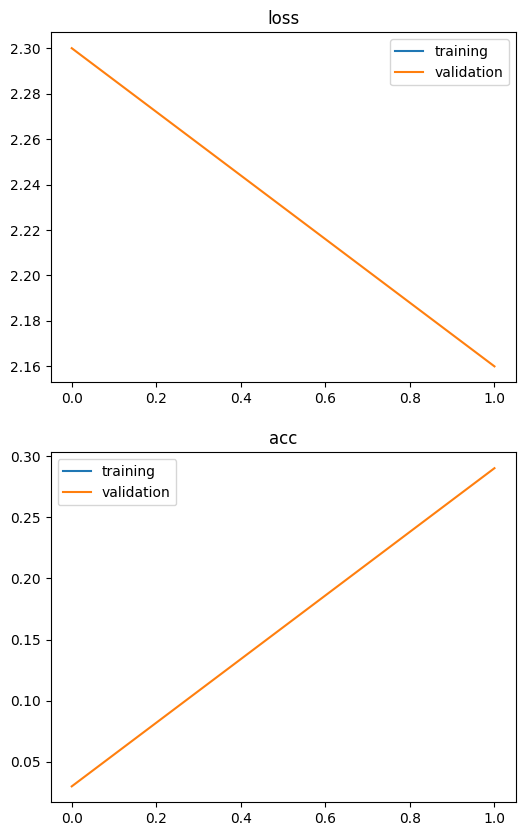

In [ ]:
best_model_path = checkpoint_callback.best_model_path
best_model = CNN.load_from_checkpoint(best_model_path).to(device)

# Use the best model for inference
best_model.eval()
best_model.freeze()

In [ ]:
criterion = nn.CrossEntropyLoss()

print('testing ...')
y_predict = list()
y_labels = list()
test_loss = 0.0
n = 0
with torch.no_grad():
    for data in tqdm(testloader):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = best_model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        y_labels += list(labels.cpu().numpy())
        y_predict += list(outputs.argmax(dim=1).cpu().numpy())
        n+=1

    # print statistics
    test_loss /= n
    print(f"testing loss: {test_loss:.4}" )

    report = classification_report(y_labels, y_predict, digits = 4)
    M = confusion_matrix(y_labels, y_predict)
    print(report)
    disp = ConfusionMatrixDisplay(confusion_matrix=M)

In [ ]:
disp.plot()
plt.show()

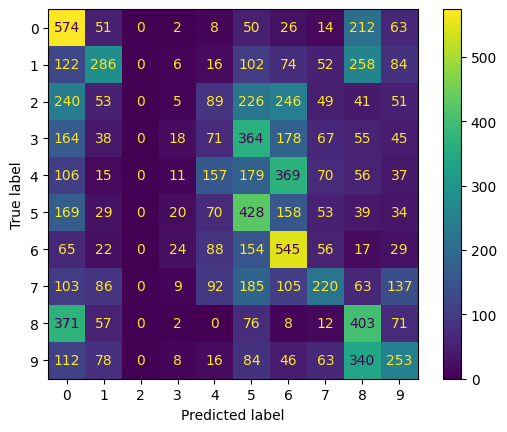

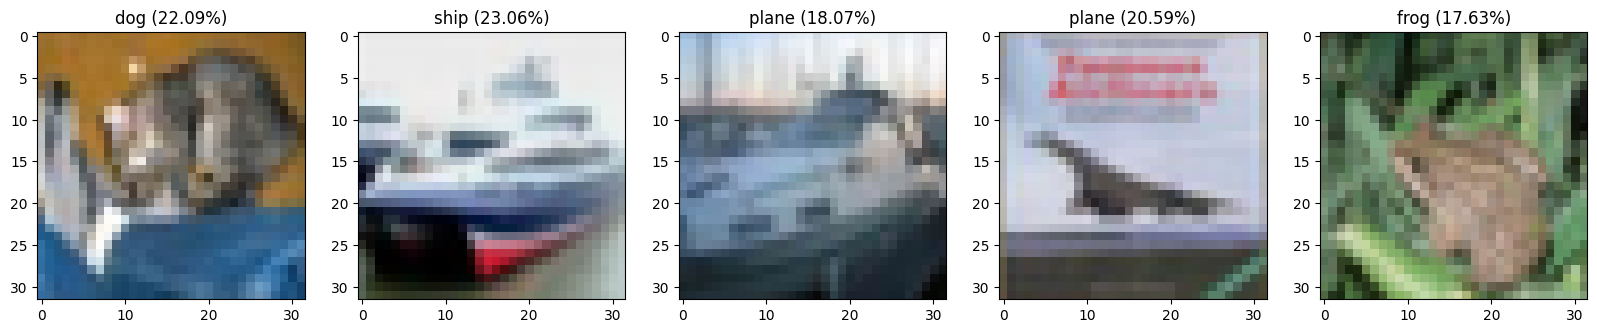

# Image classification: EfficientNetV2

#### Model
- at least 8 CNNs (Conv2dNormActivation, Sequential) -> avg pooling -> dropout -> fully connected layer
- Adam optimizer, lr=1e-3

### Dataset
- 2000 images of 10 classes ('butterfly', 'cat', 'chicken', 'cow', 'dog', 'elephant', 'horse', 'sheep', 'spider', 'squirrel')
- 1400 training, 300 validation, 300 test

#### Input
a batch (size 32) of 3-channel images of size 32x32

#### Output
a batch (size 32) of class scores (10 classes) for each image

#### Metrics
- accuracy
- loss: cross-entropy loss

## Results
after 5 epochs:
- train loss: 0.338, acc: 0.896
- val loss: 0.649, acc: 0.820
- test loss: 0.610, acc: 0.800
### macro avg
- precision: 0.822
- recall: 0.800
- f1: 0.800

In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

# data augmentation to make more data for training
transform_train = transforms.Compose(
    [transforms.Resize((230,230)),
        transforms.RandomRotation(30,),
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276]) #nomalize imagenet pretrain
    ])

transform = transforms.Compose(
    [transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
    ])

batch_size = 32

In [ ]:
class AnimalDataset(torch.utils.data.Dataset):

    def __init__(self,
                 img_dir,
                 transforms=None):

        super().__init__()
        self.label_image = ['butterfly','cat','chicken','cow','dog','elephant','horse','sheep','spider','squirrel']
        self.input_dataset = list()
        label_num = 0
        for label in self.label_image:
            _, _, files = next(os.walk(os.path.join(img_dir,label)))
            for image_name in files:
                input = [os.path.join(img_dir,label,image_name),label_num] # [image_path, label_num]
                self.input_dataset.append(input)
            label_num += 1

        self.transforms = transforms

    def __len__(self):
        return len(self.input_dataset)

    def __getitem__(self, idx):
        img = Image.open(self.input_dataset[idx][0]).convert('RGB')
        x = self.transforms(img)
        y = self.input_dataset[idx][1]
        return x,y

trainset = AnimalDataset('./Dataset_animal2/train',transform_train)
valset = AnimalDataset('./Dataset_animal2/val',transform)
testset = AnimalDataset('./Dataset_animal2/test',transform)


trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)

In [ ]:
class LitEfficientNetV2(pl.LightningModule):
    def __init__(self, num_classes=10, learning_rate=1e-3):
        super().__init__()
        # Load EfficientNetV2 model from torchvision
        self.model = models.efficientnet_v2_s(weights="IMAGENET1K_V1")
        # Replace the classifier with a custom layer for our task
        self.model.classifier[1] = nn.Linear(self.model.classifier[1].in_features, num_classes)
        self.criterion = nn.CrossEntropyLoss()
        self.accuracy = Accuracy(task="multiclass", num_classes=num_classes)
        self.learning_rate = learning_rate
        self.train_metrics = []
        self.val_metrics = []

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        acc = self.accuracy(logits.softmax(dim=-1), y)
        self.log("train_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log("train_acc", acc, on_step=False, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        acc = self.accuracy(logits.softmax(dim=-1), y)
        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log("val_acc", acc, on_step=False, on_epoch=True, prog_bar=True)

    def on_train_epoch_end(self):
        # Collect epoch metrics

        train_loss = self.trainer.callback_metrics["train_loss"]
        train_acc = self.trainer.callback_metrics["train_acc"]
        self.train_metrics.append(
            {
                "epoch": self.current_epoch,
                "train_loss": train_loss.item(),
                "train_acc": train_acc.item(),
            }
        )

    def on_validation_epoch_end(self):
        # Update validation metrics
        val_loss = self.trainer.callback_metrics["val_loss"]
        val_acc = self.trainer.callback_metrics["val_acc"]
        self.val_metrics.append(
            {
                "val_loss": val_loss.item(),
                "val_acc": val_acc.item(),
            }
        )

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

net = LitEfficientNetV2().to(device)

In [2]:
# checkpoint_callback, train, plot loss/acc code, test, confusion matrix same as before

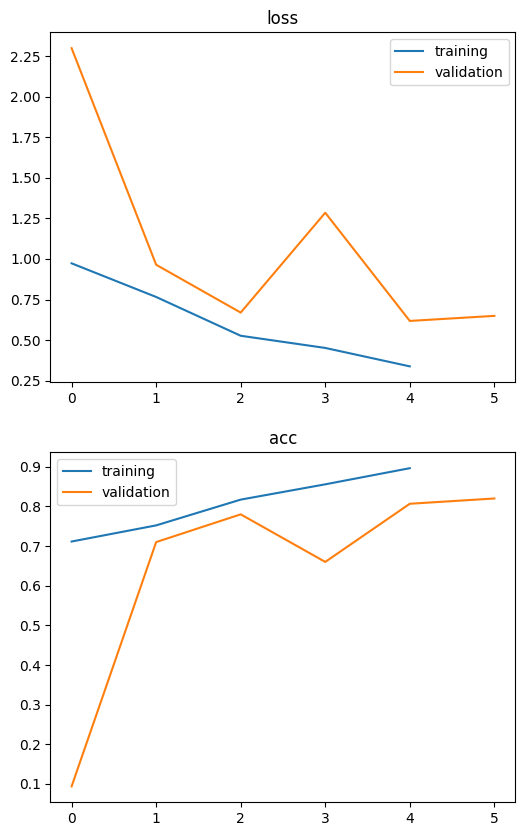

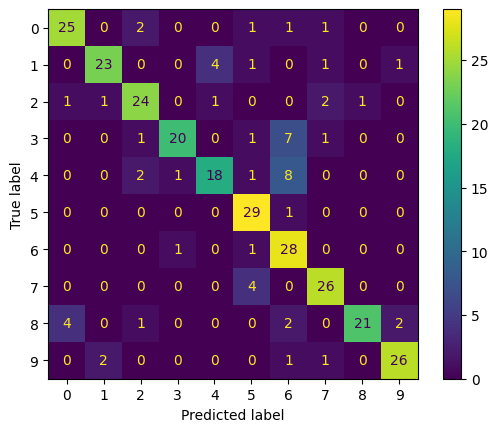

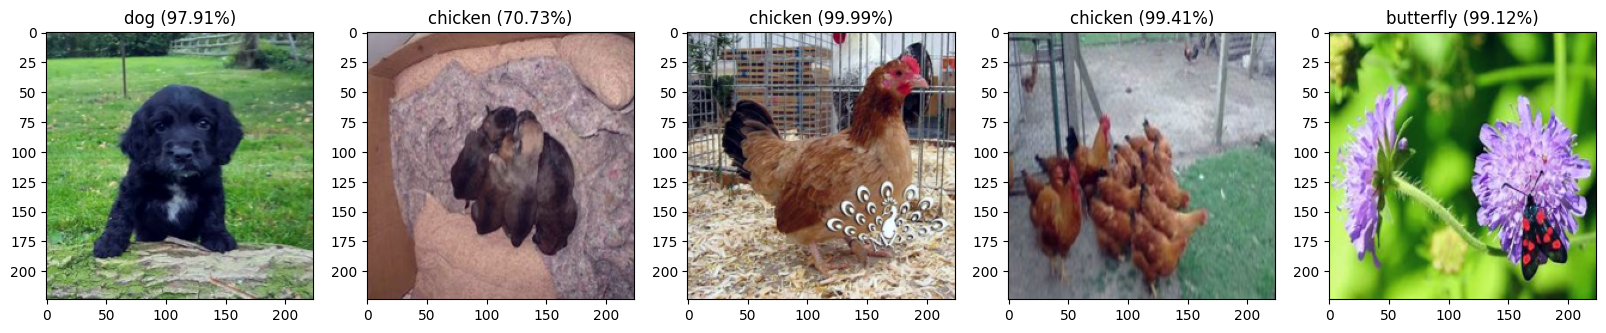